In [2]:
import io
import math
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as img
from typing import Final
from random import choices
from av2.datasets.motion_forecasting import scenario_serialization


argoverse_scenario_dir=Path("/home/guorui/Argoverse2/train/raw/")

all_scenario_files = sorted(argoverse_scenario_dir.rglob("*.parquet"))
scenario_file_list = choices(all_scenario_files, k=1)
scenario_path=scenario_file_list[0]
print(scenario_path)
_DRIVABLE_AREA_COLOR: Final[str] = "#7A7A7A"
_LANE_SEGMENT_COLOR: Final[str] = "#E0E0E0"

_DEFAULT_ACTOR_COLOR: Final[str] = "#D3E8EF"
_FOCAL_AGENT_COLOR: Final[str] = "#ECA25B"
_AV_COLOR: Final[str] = "#007672"
_BOUNDING_BOX_ZORDER: Final[int] = 100  # Ensure actor bounding boxes are plotted on top of all map elements

_STATIC_OBJECT_TYPES = {
    ObjectType.STATIC,
    ObjectType.BACKGROUND,
    ObjectType.CONSTRUCTION,
    ObjectType.RIDERLESS_BICYCLE,
}


/home/guorui/Argoverse2/train/raw/25ecfba5-0917-4d17-8f4a-63007578d350/scenario_25ecfba5-0917-4d17-8f4a-63007578d350.parquet


NameError: name 'ObjectType' is not defined

In [26]:
_ESTIMATED_VEHICLE_LENGTH_M: Final[float] = 4.0
_ESTIMATED_VEHICLE_WIDTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_LENGTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_WIDTH_M: Final[float] = 0.7
_PLOT_BOUNDS_BUFFER_M: Final[float] = 80.0

from matplotlib.patches import Rectangle
from av2.map.map_api import ArgoverseStaticMap
from av2.datasets.motion_forecasting.data_schema import ArgoverseScenario, ObjectType, TrackCategory
def _plot_static_map_elements(static_map: ArgoverseStaticMap, show_ped_xings: bool = False) -> None:
    """Plot all static map elements associated with an Argoverse scenario.

    Args:
        static_map: Static map containing elements to be plotted.
        show_ped_xings: Configures whether pedestrian crossings should be plotted.
    """
    # Plot drivable areas
    for drivable_area in static_map.vector_drivable_areas.values():
        _plot_polygons([drivable_area.xyz], alpha=0.5, color=_DRIVABLE_AREA_COLOR)

    # Plot lane segments
    for lane_segment in static_map.vector_lane_segments.values():
        _plot_polylines(
            [
                lane_segment.left_lane_boundary.xyz,
                lane_segment.right_lane_boundary.xyz,
            ],
            line_width=0.5,
            color=_LANE_SEGMENT_COLOR,
        )

    # Plot pedestrian crossings
    if show_ped_xings:
        for ped_xing in static_map.vector_pedestrian_crossings.values():
            _plot_polylines([ped_xing.edge1.xyz, ped_xing.edge2.xyz], alpha=1.0, color=_LANE_SEGMENT_COLOR)


def _plot_actor_tracks(ax: plt.Axes, scenario, timestep: int) :
    """Plot all actor tracks (up to a particular time step) associated with an Argoverse scenario.

    Args:
        ax: Axes on which actor tracks should be plotted.
        scenario: Argoverse scenario for which to plot actor tracks.
        timestep: Tracks are plotted for all actor data up to the specified time step.

    Returns:
        track_bounds: (x_min, x_max, y_min, y_max) bounds for the extent of actor tracks.
    """
    track_bounds = None
    for track in scenario.tracks:
        # Get timesteps for which actor data is valid
        actor_timesteps: NDArrayInt = np.array(
            [object_state.timestep for object_state in track.object_states if object_state.timestep <= timestep]
        )
        if actor_timesteps.shape[0] < 1 or actor_timesteps[-1] != timestep:
            continue

        # Get actor trajectory and heading history
        actor_trajectory: NDArrayFloat = np.array(
            [list(object_state.position) for object_state in track.object_states if object_state.timestep <= timestep]
        )
        actor_headings: NDArrayFloat = np.array(
            [object_state.heading for object_state in track.object_states if object_state.timestep <= timestep]
        )

        # Plot polyline for focal agent location history
        track_color = _DEFAULT_ACTOR_COLOR
        if track.category == TrackCategory.FOCAL_TRACK:
            x_min, x_max = actor_trajectory[:, 0].min(), actor_trajectory[:, 0].max()
            y_min, y_max = actor_trajectory[:, 1].min(), actor_trajectory[:, 1].max()
            track_bounds = (x_min, x_max, y_min, y_max)
            track_color = _FOCAL_AGENT_COLOR
            _plot_polylines([actor_trajectory], color=track_color, line_width=2)
            _plot_polylines([np.array(
            [list(object_state.position) for object_state in track.object_states if object_state.timestep > timestep]
        )], color="black", line_width=2, style='--')
        elif track.track_id == "AV":
            track_color = _AV_COLOR
        elif track.object_type in _STATIC_OBJECT_TYPES:
            continue

        # Plot bounding boxes for all vehicles and cyclists
        if track.object_type == ObjectType.VEHICLE:
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_VEHICLE_LENGTH_M, _ESTIMATED_VEHICLE_WIDTH_M),
            )
        elif track.object_type == ObjectType.CYCLIST or track.object_type == ObjectType.MOTORCYCLIST:
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_CYCLIST_LENGTH_M, _ESTIMATED_CYCLIST_WIDTH_M),
            )
        else:
            plt.plot(actor_trajectory[-1, 0], actor_trajectory[-1, 1], "o", color=track_color, markersize=4)

    return track_bounds


def _plot_polylines(
    polylines,
    *,
    style: str = "-",
    line_width: float = 1.0,
    alpha: float = 1.0,
    color: str = "r",
) -> None:
    """Plot a group of polylines with the specified config.

    Args:
        polylines: Collection of (N, 2) polylines to plot.
        style: Style of the line to plot (e.g. `-` for solid, `--` for dashed)
        line_width: Desired width for the plotted lines.
        alpha: Desired alpha for the plotted lines.
        color: Desired color for the plotted lines.
    """
    for polyline in polylines:
        plt.plot(polyline[:, 0], polyline[:, 1], style, linewidth=line_width, color=color, alpha=alpha)


def _plot_polygons(polygons, *, alpha: float = 1.0, color: str = "r") -> None:
    """Plot a group of filled polygons with the specified config.

    Args:
        polygons: Collection of polygons specified by (N,2) arrays of vertices.
        alpha: Desired alpha for the polygon fill.
        color: Desired color for the polygon.
    """
    for polygon in polygons:
        plt.fill(polygon[:, 0], polygon[:, 1], color=color, alpha=alpha)


def _plot_actor_bounding_box(
    ax: plt.Axes, cur_location, heading: float, color: str, bbox_size
) -> None:
    """Plot an actor bounding box centered on the actor's current location.

    Args:
        ax: Axes on which actor bounding box should be plotted.
        cur_location: Current location of the actor (2,).
        heading: Current heading of the actor (in radians).
        color: Desired color for the bounding box.
        bbox_size: Desired size for the bounding box (length, width).
    """
    (bbox_length, bbox_width) = bbox_size

    # Compute coordinate for pivot point of bounding box
    d = np.hypot(bbox_length, bbox_width)
    theta_2 = math.atan2(bbox_width, bbox_length)
    pivot_x = cur_location[0] - (d / 2) * math.cos(heading + theta_2)
    pivot_y = cur_location[1] - (d / 2) * math.sin(heading + theta_2)

    vehicle_bounding_box = Rectangle(
        (pivot_x, pivot_y), bbox_length, bbox_width, np.degrees(heading), color=color, zorder=_BOUNDING_BOX_ZORDER
    )
    ax.add_patch(vehicle_bounding_box)


/tmp/ipykernel_164063/1605822620.py:158: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


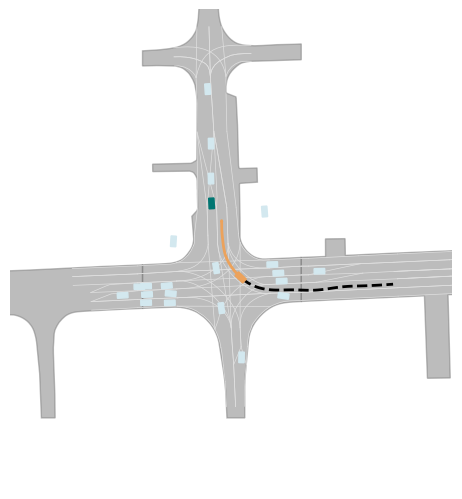

In [27]:

scenario_id = scenario_path.stem.split("_")[-1]
static_map_path = (
    scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"
)

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)

frames = []
plot_bounds = (0, 0, 0, 0)

# for timestep in range(110):
_, ax = plt.subplots()

# Plot static map elements and actor tracks
_plot_static_map_elements(scenario_static_map)
cur_plot_bounds = _plot_actor_tracks(ax, scenario, 50)
if cur_plot_bounds:
    plot_bounds = cur_plot_bounds

# Set map bounds to capture focal trajectory history (with fixed buffer in all directions)
plt.xlim(
    plot_bounds[0] - _PLOT_BOUNDS_BUFFER_M,
    plot_bounds[1] + _PLOT_BOUNDS_BUFFER_M,
)
plt.ylim(
    plot_bounds[2] - _PLOT_BOUNDS_BUFFER_M,
    plot_bounds[3] + _PLOT_BOUNDS_BUFFER_M,
)
plt.gca().set_aspect("equal", adjustable="box")

# Minimize plot margins and make axes invisible
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Save plotted frame to in-memory buffer
